# Import Packages and Data

In [1]:
# import necessary libraries
import numpy as np
from scipy.spatial import distance_matrix
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.sql.functions import explode
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# instantiate SparkSession object
spark = SparkSession\
        .builder\
        .appName("ALSExample").config("spark.driver.host","localhost")\
        .getOrCreate()

In [3]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('../data/test_data/ratings.csv', header='true', inferSchema = 'true')


In [4]:
movie_ratings = movie_ratings.drop('timestamp')


# Grid Search Optimal Hyperparameters with Cross Validation

In [5]:
als_model =  ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
               
params = ParamGridBuilder().addGrid(als_model.regParam, [0.15]).addGrid(als_model.rank, [42]).build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
## instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

In [6]:
predictions = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.633102568829379


In [7]:
rank = best_model.bestModel.rank
rank

42

In [8]:
best_model.getEstimatorParamMaps()

[{Param(parent='ALS_36cc948ff8d3', name='regParam', doc='regularization parameter (>= 0).'): 0.15,
  Param(parent='ALS_36cc948ff8d3', name='rank', doc='rank of the factorization'): 42}]

In [9]:
best_model.avgMetrics

[0.8868074494252955]

## Run Model with full data using parameters from grid search

In [10]:
user_factors = best_model.bestModel.userFactors
user_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.32554427, -0....|
| 20|[-0.26986122, 0.2...|
| 30|[-0.22513156, -0....|
| 40|[-0.18808979, -0....|
| 50|[-0.03185513, -0....|
| 60|[-0.32429707, -0....|
| 70|[-0.25335753, -0....|
| 80|[-0.29276082, -0....|
| 90|[-0.24342096, 0.1...|
|100|[-0.22938769, -0....|
|110|[-0.032225385, -0...|
|120|[-0.3968513, -0.0...|
|130|[-0.3055488, -0.1...|
|140|[-0.4457157, -0.1...|
|150|[-0.24412441, -0....|
|160|[-0.11795274, 0.1...|
|170|[-0.18095309, -0....|
|180|[-0.20168817, -0....|
|190|[-0.12318171, -0....|
|200|[-0.24537581, -0....|
+---+--------------------+
only showing top 20 rows



In [11]:
recommendationsDF = (user_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

display(recommendationsDF.show())

+---+------------+
| id|    features|
+---+------------+
| 10| -0.32554427|
| 10|  -0.1798861|
| 10|  0.14299951|
| 10|  0.24096172|
| 10| -0.14422582|
| 10|  0.29612115|
| 10| -0.46486768|
| 10|   0.7438849|
| 10|  0.13574708|
| 10|  0.23644093|
| 10| -0.28702086|
| 10| -0.16834298|
| 10| -0.16396445|
| 10| -0.28236032|
| 10| -0.08362007|
| 10| -0.21505848|
| 10|-0.045850012|
| 10| -0.07694744|
| 10| -0.32202893|
| 10|  0.23243363|
+---+------------+
only showing top 20 rows



None

In [12]:
rec_pdf = recommendationsDF.toPandas()
rec_pdf.head()

,id,features
0,10,-0.325544
1,10,-0.179886
2,10,0.143000
3,10,0.240962
4,10,-0.144226


In [13]:
multiplier = rec_pdf['id'].nunique()
feature_array = np.array(list(range(1,rank+1))*multiplier)
rec_pdf['value'] = feature_array

In [14]:
rec_pdf_unstacked = rec_pdf.pivot(index='id', columns='value', values='features')

In [15]:
rec_pdf_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,-0.211598,-0.092850,-0.368816,0.497501,-0.185388,0.406564,-0.188933,0.490727,0.196783,0.459668,...,-0.089325,-0.695794,-0.249500,0.269462,0.057917,-0.098235,-0.477075,-0.290220,0.355792,0.478584
2,-0.113180,-0.347372,-0.194752,0.184049,-0.151814,0.396433,-0.030188,0.659873,0.064771,0.265386,...,-0.050948,-0.521656,-0.301876,0.066322,0.225299,-0.271554,-0.470888,0.065140,0.316713,0.258564
3,0.244105,0.127526,-0.761715,-0.019149,-0.099812,0.465599,0.282014,-0.253082,0.141436,-0.057426,...,0.028086,0.128897,0.003071,-0.075155,-0.244906,-0.915128,0.327621,0.304608,0.258876,0.412193
4,-0.298305,-0.140523,-0.187560,0.530183,0.223523,0.098104,-0.518510,0.504591,-0.110630,0.774318,...,-0.163831,-0.089006,0.047734,0.359976,0.132251,0.139180,-0.406303,-0.513254,0.212724,0.063179
5,-0.211569,-0.108872,-0.198080,0.604222,-0.177598,0.126212,-0.104335,0.483865,-0.050782,0.274744,...,-0.171709,-0.277769,0.020418,0.084225,-0.001791,0.032742,-0.325224,-0.258397,0.178237,0.143826


# Hierarchical Agglomerative Cluster Analysis

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rec_pdf_scaled = scaler.fit_transform(rec_pdf_unstacked)

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


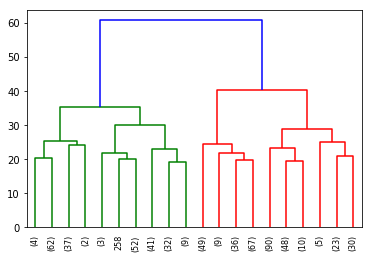

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline

z = linkage(rec_pdf_scaled, 'ward', metric = 'euclidean') # Ward linkage used to produce tightly knit clusters
c, coph_dist = cophenet(z, pdist(rec_pdf_scaled))
dendrogram(z,
          leaf_rotation=90,
          leaf_font_size = 8.,
          truncate_mode='lastp',
          p=20)
plt.show()

In [18]:
coph_dist.sort()
set(coph_dist)

{1.8152162826593183,
 1.8518358949796938,
 2.021445682996286,
 2.0271488360991774,
 2.110070752732634,
 2.1823421922344624,
 2.298818411759436,
 2.3499974318719463,
 2.4133857180288265,
 2.418945557457899,
 2.4544532020856287,
 2.4677040270899124,
 2.469114816103561,
 2.4782987926175184,
 2.5110622181677065,
 2.539403714909395,
 2.6093147969711774,
 2.6477837581946497,
 2.657153276701418,
 2.7030565922978718,
 2.7419655507598266,
 2.750208998266655,
 2.7572457868005804,
 2.787251383452463,
 2.794842115265426,
 2.82220198939781,
 2.8341508273653284,
 2.8456354304144713,
 2.8870467989528565,
 2.896925451775092,
 2.9130543349864055,
 2.9449869738670493,
 2.956639484047373,
 2.958054511964833,
 2.9737513159699214,
 2.975590078444344,
 3.023771403008262,
 3.0268956969630674,
 3.0290851768282945,
 3.0600058227047513,
 3.0652727357178593,
 3.0783617100523695,
 3.091581658458488,
 3.0936409356000896,
 3.151522945564002,
 3.1639896227358024,
 3.197566613503584,
 3.2007538532119737,
 3.210656191

In [19]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import pandas as pd
rec_pdf_clustered = pd.DataFrame(rec_pdf_scaled.copy())
cluster = AgglomerativeClustering(n_clusters=5, 
                                 affinity='euclidean',
                                 linkage='ward')
rec_pdf_clustered['cluster'] = cluster.fit_predict(rec_pdf_clustered)

In [20]:
rec_pdf_clustered.groupby(['cluster']).agg(['mean', 'std', 'count'])

0                         1                         2   \
             mean       std count      mean       std count      mean   
cluster                                                                 
0       -0.129921  0.857163   206 -0.129574  0.961650   206  0.053554   
1       -0.630553  0.944215   105 -0.424976  0.966532   105  0.058025   
2        0.444266  1.008627   161  0.398947  0.929369   161 -0.319530   
3       -0.010687  0.909218    82 -0.145667  0.984871    82  0.205184   
4        0.398594  0.963124    56  0.339805  0.955845    56  0.312403   

                               3   ...    38        39                  \
              std count      mean  ... count      mean       std count   
cluster                            ...                                   
0        1.033438   206 -0.168661  ...   206  0.026252  1.002182   206   
1        0.952912   105  0.396760  ...   105  0.019146  1.134961   105   
2        0.997068   161  0.259326  ...   161 -0.121627  1.014517   161   
3        0.869494    82 -0.741125  ...    82  0.099869  0.842719    82   
4        0.953691    56  0.216165  ...    56  0.070971  0.897197    56   

               40                        41                  
             mean       std count      mean       std count  
cluster                                                      
0        0.063511  0.766158   206  0.174929  0.908726   206  
1        0.270193  1.038703   105 -0.315368  1.055379   105  
2       -0.748903  0.866019   161 -0.302684  0.946968   161  
3        0.938013  0.833640    82  0.354996  1.009064    82  
4        0.039338  0.740264    56  0.298227  0.973377    56  

[5 rows x 126 columns]

In [21]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(111, projection='3d')
# plt.scatter(rec_pdf_clustered[1], rec_pdf_clustered[5], rec_pdf_clustered[3], c=rec_pdf_clustered.cluster)
# plt.show();

In [22]:
cluster_centroids = rec_pdf_clustered.groupby(['cluster']).agg('mean')

In [23]:
cluster_centroids_array = cluster_centroids.to_numpy()

In [24]:
cluster_distance_matrix = distance_matrix(cluster_centroids_array, cluster_centroids_array, p=2)

In [25]:
cluster_distance_df = pd.DataFrame(cluster_distance_matrix)
cluster_distance_df

,0,1,2,3,4
0,0.000000,3.658481,3.003617,3.314161,3.425351
1,3.658481,0.000000,5.230256,3.823907,3.531880
2,3.003617,5.230256,0.000000,5.892781,4.514757
3,3.314161,3.823907,5.892781,0.000000,3.668879
4,3.425351,3.531880,4.514757,3.668879,0.000000


In [26]:
def nearest_clusters(cluster, num_nearest_clusters=2):
    sorted_distances = cluster_distance_df[cluster].sort_values(ascending=True)
    return sorted_distances[1:num_nearest_clusters+1].index.values.astype(int)

In [27]:
nearest_clusters(0, 2)

array([2, 3])

# Bootstrap Sample

In [28]:
bs_sample = rec_pdf_clustered.sample(n=5000, replace=True, axis=0, random_state=42)

# KNN Model (for assigning new user to a cluster)

In [29]:
bs_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,cluster
102,0.630060,-0.267890,0.188085,-0.396728,0.349898,-0.702867,-0.277761,0.311371,0.506272,0.011693,...,-0.224183,-0.094395,1.290319,-0.394938,0.115997,0.548908,0.402364,0.006766,-0.056686,0
435,-0.004826,0.153284,-0.294713,0.907443,-0.600041,-0.520312,-0.652250,-0.550249,-0.393026,0.490168,...,-0.195666,-0.657758,-0.001888,0.106748,0.862701,1.061276,0.162618,0.120004,-1.152326,1
270,0.675991,0.697192,-0.921068,-0.716004,-0.495324,-0.842726,-0.423179,-0.792351,-0.308476,0.281338,...,1.642665,0.514098,-0.014494,-2.038713,-1.047920,1.564549,0.875388,0.060255,-0.164189,0
106,-0.892260,-0.828349,0.126836,0.591580,-1.362618,-0.024942,-1.344929,-0.400489,0.433960,0.118547,...,-0.753036,-1.143579,-0.176597,0.685269,-0.211006,0.144385,-0.414328,0.805360,-0.107977,1
71,-0.273057,-0.056058,0.194359,-0.010129,-0.573881,-0.089710,-0.332308,0.099354,0.278620,0.051445,...,-0.464340,0.300666,0.149806,-0.251268,-0.259710,-0.687326,-0.305342,0.326141,0.195115,0


In [30]:
X = bs_sample.iloc[:,:-1]
y = bs_sample.iloc[:,-1]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [32]:
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_test)
accuracy_score(y_test, test_preds), accuracy_score(y_train, train_preds)

(0.964, 0.9850666666666666)

In [33]:
print(confusion_matrix(y_test, test_preds))
print(confusion_matrix(y_train, train_preds))

[[426   0   2   3   0]
 [  3 214   0   0   0]
 [  2   0 307   1   0]
 [  6   5   0 149   0]
 [ 17   6   0   0 109]]
[[1289    0    3    5    0]
 [   2  646    0    2    0]
 [   7    0  970    3    0]
 [  11    2    0  474    0]
 [  17    4    0    0  315]]


# Nearest Centroid

In [34]:
from sklearn.neighbors import NearestCentroid
nc = NearestCentroid()
nc.fit(X_train, y_train)
nc_train_preds = nc.predict(X_train)
nc_test_preds = nc.predict(X_test)
accuracy_score(y_test, nc_test_preds), accuracy_score(y_train, nc_train_preds)

(0.756, 0.7712)

In [35]:
print(confusion_matrix(y_test, nc_test_preds))
print(confusion_matrix(y_train, nc_train_preds))

[[296  25  49  36  25]
 [ 14 170  18  10   5]
 [ 44   4 249   1  12]
 [ 12   3   0 135  10]
 [  9   9   3  16  95]]
[[916  89 127  92  73]
 [ 29 525  54  32  10]
 [125   7 808   3  37]
 [ 40   7   0 403  37]
 [ 15  32   5  44 240]]


# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
dc = DecisionTreeClassifier(max_depth=8, max_features=8, criterion='gini', min_samples_leaf=9)
dc.fit(X_train, y_train)
dc_train_preds = dc.predict(X_train)
dc_test_preds = dc.predict(X_test)
accuracy_score(y_test, dc_test_preds), accuracy_score(y_train, dc_train_preds)

(0.8728, 0.8976)

In [37]:
print(confusion_matrix(y_test, dc_test_preds))
print(confusion_matrix(y_train, dc_train_preds))

[[399   2  23   5   2]
 [ 25 177   2   7   6]
 [ 17   6 284   1   2]
 [ 22   6   3 123   6]
 [ 14   3   7   0 108]]
[[1233   10   32   18    4]
 [  61  545   13   14   17]
 [  60   15  898    3    4]
 [  60   12    3  403    9]
 [  36    6    7    0  287]]


# Random Forest

In [38]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
param_grid = {'criterion':['gini', 'entropy'], 
             'max_depth': [15],
             'min_samples_split': [5],
             'n_estimators': [50],
             'max_features': [6]}
gs_forest = GridSearchCV(rf, param_grid, cv=5)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 6,
 'min_samples_split': 5,
 'n_estimators': 50}

In [39]:
gs_forest_train_preds = gs_forest.predict(X_train)
gs_forest_test_preds = gs_forest.predict(X_test)
accuracy_score(y_test, gs_forest_test_preds), accuracy_score(y_train, gs_forest_train_preds)

(1.0, 1.0)

In [40]:
print(confusion_matrix(y_test, gs_forest_test_preds))
print(confusion_matrix(y_train, gs_forest_train_preds))

[[431   0   0   0   0]
 [  0 217   0   0   0]
 [  0   0 310   0   0]
 [  0   0   0 160   0]
 [  0   0   0   0 132]]
[[1297    0    0    0    0]
 [   0  650    0    0    0]
 [   0    0  980    0    0]
 [   0    0    0  487    0]
 [   0    0    0    0  336]]


# AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(learning_rate=.4)
ab.fit(X_train, y_train)
ab_train_preds = ab.predict(X_train)
ab_test_preds = ab.predict(X_test)
accuracy_score(y_test, ab_test_preds), accuracy_score(y_train, ab_train_preds)

(0.76, 0.7741333333333333)

In [42]:
print(confusion_matrix(y_test, ab_test_preds))
print(confusion_matrix(y_train, ab_train_preds))

[[391  17  17   2   4]
 [ 39 152   8  15   3]
 [111   0 193   0   6]
 [ 34   1   0 121   4]
 [ 23   7   3   6  93]]
[[1187   44   39    8   19]
 [  81  474   24   40   31]
 [ 296    0  665    0   19]
 [ 110   15    0  349   13]
 [  70   20    5   13  228]]


# Gradient Boosting Classifier

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
param_grid = {'learning_rate':[.15], 
             'max_depth': [5],
             'min_samples_split': [25],
             'n_estimators': [41],
             'max_features': [7]}
gs_gbc = GridSearchCV(gbc, param_grid, cv=5)
gs_gbc.fit(X_train, y_train)
gbc_train_preds = gs_gbc.predict(X_train)
gbc_test_preds = gs_gbc.predict(X_test)
accuracy_score(y_test, gbc_test_preds), accuracy_score(y_train, gbc_train_preds)

(1.0, 1.0)

In [44]:
gs_gbc.best_params_

{'learning_rate': 0.15,
 'max_depth': 5,
 'max_features': 7,
 'min_samples_split': 25,
 'n_estimators': 41}

In [45]:
print(confusion_matrix(y_test, gbc_test_preds))
print(confusion_matrix(y_train, gbc_train_preds))

[[431   0   0   0   0]
 [  0 217   0   0   0]
 [  0   0 310   0   0]
 [  0   0   0 160   0]
 [  0   0   0   0 132]]
[[1297    0    0    0    0]
 [   0  650    0    0    0]
 [   0    0  980    0    0]
 [   0    0    0  487    0]
 [   0    0    0    0  336]]


# Item Feature Extraction

In [46]:
item_factors = best_model.bestModel.itemFactors
item_factors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.2663651, -0.2...|
| 20|[-0.09511721, -0....|
| 30|[0.024989937, 0.0...|
| 40|[-0.18011186, -0....|
| 50|[-0.25008246, -0....|
| 60|[-0.13278572, -0....|
| 70|[0.11483895, -0.1...|
| 80|[-0.08103209, -0....|
|100|[-0.29916978, -0....|
|110|[-0.41751948, -0....|
|140|[-0.3304135, -0.2...|
|150|[-0.37294686, -0....|
|160|[-0.16781883, -0....|
|170|[-0.011277504, -0...|
|180|[-0.107585944, -0...|
|190|[0.29043248, -0.0...|
|210|[-0.11443502, -0....|
|220|[0.012158493, -0....|
|230|[-0.13257946, -0....|
|240|[0.06502196, -0.0...|
+---+--------------------+
only showing top 20 rows



In [47]:
item_factors_df = (item_factors
  .select("id", explode("features")
  .alias("features"))
  .select('id',"features")
)

display(item_factors_df.show())

+---+------------+
| id|    features|
+---+------------+
| 10|  -0.2663651|
| 10| -0.29368177|
| 10| -0.07946881|
| 10|  0.09086499|
| 10| -0.23289499|
| 10|  0.38993293|
| 10| -0.22302248|
| 10|   0.5194347|
| 10|   0.1667314|
| 10|   0.3732692|
| 10|  0.09583826|
| 10|  -0.4100131|
| 10| -0.14149654|
| 10| -0.17086741|
| 10|  -0.5463672|
| 10|  -0.3317461|
| 10| 0.063021384|
| 10|-0.053559825|
| 10| -0.12135654|
| 10|  0.32843298|
+---+------------+
only showing top 20 rows



None

In [48]:
item_factors_pdf = item_factors_df.toPandas()
item_factors_pdf.head()

,id,features
0,10,-0.266365
1,10,-0.293682
2,10,-0.079469
3,10,0.090865
4,10,-0.232895


In [49]:
multiplier_factors = item_factors_pdf['id'].nunique()
factors_feature_array = np.array(list(range(1,rank+1))*multiplier_factors)
item_factors_pdf['value'] = factors_feature_array
item_factors_unstacked = item_factors_pdf.pivot(index='id', columns='value', values='features')
item_factors_unstacked.head()

value,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
id,,,,,,,,,,,,,,,,,,,,,
1,-0.174592,-0.135860,-0.308489,0.388533,-0.313299,0.310482,-0.133676,0.561055,-0.020057,0.286569,...,-0.156431,-0.471305,-0.196119,0.084702,0.158160,-0.046850,-0.490982,-0.249497,0.179509,0.138472
2,-0.099808,-0.113895,-0.290692,0.203978,-0.414492,0.276230,-0.335279,0.443521,0.171580,0.324302,...,-0.086234,-0.401285,-0.215090,0.089038,0.121085,-0.153165,-0.416040,-0.055355,0.394160,0.199257
3,-0.128914,-0.216055,-0.159279,0.226630,-0.167005,0.246337,-0.085128,0.472754,0.430414,0.257249,...,-0.166166,-0.422336,-0.325507,0.197633,0.312755,-0.155875,-0.249452,-0.031584,0.349551,0.090179
4,-0.167422,-0.224619,-0.121928,0.307145,-0.389068,0.093790,-0.187494,0.445634,0.280914,0.341443,...,-0.207991,-0.226302,-0.287932,-0.008719,0.214146,0.121412,-0.364746,-0.059990,0.204035,0.011945
5,-0.170471,-0.065946,-0.207230,0.173303,-0.194004,0.221864,-0.161712,0.370933,0.192685,0.274412,...,-0.100088,-0.359768,-0.316772,0.146115,0.029403,-0.123264,-0.211894,0.034125,0.502564,0.079977


# Cluster Centroids

In [50]:
cluster_centroids_df = pd.DataFrame(cluster_centroids_array)
cluster_centroids_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,-0.129921,-0.129574,0.053554,-0.168661,-0.012303,0.115606,0.161021,-0.067672,-0.116663,-0.185334,...,0.210019,0.066455,0.156214,0.021401,-0.157105,-0.346726,-0.162998,0.026252,0.063511,0.174929
1,-0.630553,-0.424976,0.058025,0.396760,-0.874319,-0.028537,-0.584642,0.073381,0.719330,0.054540,...,-0.802659,-0.110082,-0.673015,-0.228890,0.763662,0.429462,0.072674,0.019146,0.270193,-0.315368
2,0.444266,0.398947,-0.319530,0.259326,0.633895,-0.731714,0.254737,-0.444219,-0.319370,0.397566,...,0.282037,0.620020,0.815398,-0.048607,-0.486889,0.192842,0.416432,-0.121627,-0.748903,-0.302684
3,-0.010687,-0.145667,0.205184,-0.741125,-0.372026,1.071378,0.016468,0.472335,0.085641,-0.426036,...,0.007228,-0.782126,-0.841701,0.022006,0.090508,-0.664228,-0.335842,0.099869,0.938013,0.354996
4,0.398594,0.339805,0.312403,0.216165,0.406909,0.163116,-0.252605,0.696841,-0.126807,0.060340,...,-0.089024,-0.675358,-0.424518,0.457963,0.413332,0.888415,-0.242141,0.070971,0.039338,0.298227


In [51]:
cluster_centroids.shape

(5, 42)

In [52]:
item_factors_unstacked_transposed = item_factors_unstacked.T

In [53]:
centroid_ratings = np.dot(cluster_centroids, item_factors_unstacked_transposed)

In [54]:
centroid_ratings_df = pd.DataFrame(centroid_ratings)
centroid_ratings_df.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,-0.417409,-0.366273,-0.235463,-0.353626,-0.358549,0.268852,-0.578123,-0.321495,-0.239414,0.120343,...,0.046292,0.039679,0.052905,0.052905,0.046292,0.052905,0.046292,0.046292,0.046292,0.143561
1,1.211990,1.790171,1.470220,2.071086,1.525467,0.288718,2.014942,1.403710,1.495618,0.670696,...,-0.396639,-0.339977,-0.453302,-0.453302,-0.396639,-0.453302,-0.396639,-0.396639,-0.396639,-0.807583
2,-1.393505,-1.994537,-1.563364,-1.685560,-1.891759,-0.850701,-1.418113,-2.052308,-2.215465,-1.887349,...,-0.327158,-0.280421,-0.373895,-0.373895,-0.327158,-0.373895,-0.327158,-0.327158,-0.327158,0.308182
3,1.674205,2.107768,1.515507,1.081301,2.198129,1.156990,1.166374,2.847100,2.794165,2.520093,...,0.976107,0.836663,1.115551,1.115551,0.976107,1.115551,0.976107,0.976107,0.976107,0.144987
4,0.817803,0.638712,0.385041,0.680205,0.678817,-0.778737,0.717822,0.282103,0.354422,0.035745,...,0.084691,0.072592,0.096790,0.096790,0.084691,0.096790,0.084691,0.084691,0.084691,-0.112207


In [55]:
centroid_ratings_df.columns = item_factors_unstacked.index
centroid_ratings_df.head()

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,-0.417409,-0.366273,-0.235463,-0.353626,-0.358549,0.268852,-0.578123,-0.321495,-0.239414,0.120343,...,0.046292,0.039679,0.052905,0.052905,0.046292,0.052905,0.046292,0.046292,0.046292,0.143561
1,1.211990,1.790171,1.470220,2.071086,1.525467,0.288718,2.014942,1.403710,1.495618,0.670696,...,-0.396639,-0.339977,-0.453302,-0.453302,-0.396639,-0.453302,-0.396639,-0.396639,-0.396639,-0.807583
2,-1.393505,-1.994537,-1.563364,-1.685560,-1.891759,-0.850701,-1.418113,-2.052308,-2.215465,-1.887349,...,-0.327158,-0.280421,-0.373895,-0.373895,-0.327158,-0.373895,-0.327158,-0.327158,-0.327158,0.308182
3,1.674205,2.107768,1.515507,1.081301,2.198129,1.156990,1.166374,2.847100,2.794165,2.520093,...,0.976107,0.836663,1.115551,1.115551,0.976107,1.115551,0.976107,0.976107,0.976107,0.144987
4,0.817803,0.638712,0.385041,0.680205,0.678817,-0.778737,0.717822,0.282103,0.354422,0.035745,...,0.084691,0.072592,0.096790,0.096790,0.084691,0.096790,0.084691,0.084691,0.084691,-0.112207


In [56]:
len(centroid_ratings_df.columns)

9724

In [57]:
centroid_ratings_T_df = centroid_ratings_df.transpose()
centroid_ratings_T_df.head()

,0,1,2,3,4
id,,,,,
1,-0.417409,1.211990,-1.393505,1.674205,0.817803
2,-0.366273,1.790171,-1.994537,2.107768,0.638712
3,-0.235463,1.470220,-1.563364,1.515507,0.385041
4,-0.353626,2.071086,-1.685560,1.081301,0.680205
5,-0.358549,1.525467,-1.891759,2.198129,0.678817


# New User Data

In [131]:
md = movie_ratings.toPandas()
R = md.pivot(index='userId', columns='movieId', values='rating')
mean_ratings = pd.DataFrame(np.mean(R))
mean_ratings = mean_ratings.reset_index()
total_recs = (md['movieId'].value_counts()).reset_index()
total_recs.columns = ['movieId', 'total_recs']
total_recs = total_recs[total_recs['total_recs']>50]
most_rated = pd.merge(total_recs, mean_ratings, how='left', on='movieId')
most_rated_sorted = most_rated.sort_values(by=0, ascending=False )
top_100 = most_rated_sorted[:100]
top_100 = pd.merge(top_100, movies_df, how='left', on='movieId')

In [58]:
user_id = 100000
user_ratings_1 = [(user_id,3253,5),
                  (user_id,2459,5),
                  (user_id,2513,4),
                  (user_id,6502,5),
                  (user_id,1091,5),
                  (user_id,441,4)]

## ALS recommendations

In [59]:
rated_movies = [3253,2459,2513,6502,1091,441]
rated_item_factor = item_factors_pdf.loc[item_factors_pdf['id'].isin(rated_movies)].pivot(index='id', columns='value', values='features')
M = rated_item_factor.as_matrix()
E = np.identity(rank)
nui = 6
regParam = 0.01
A = M.dot(M.T)
R = np.array([x[2] for x in user_ratings_1])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
A = M.T.dot(M)+regParam*nui*E
V = M.T.dot(R.T)

In [61]:
A

array([[ 0.37335011,  0.17509985,  0.19506104, ...,  0.01628589,
        -0.30347362, -0.11705472],
       [ 0.17509985,  0.36065286,  0.13554946, ...,  0.0304503 ,
        -0.15814474, -0.29399693],
       [ 0.19506104,  0.13554946,  0.39458331, ..., -0.0137781 ,
        -0.34531704, -0.23750106],
       ...,
       [ 0.01628589,  0.0304503 , -0.0137781 , ...,  0.14577216,
        -0.04005625,  0.01435709],
       [-0.30347362, -0.15814474, -0.34531704, ..., -0.04005625,
         0.54766971,  0.22797516],
       [-0.11705472, -0.29399693, -0.23750106, ...,  0.01435709,
         0.22797516,  0.51090392]])

In [62]:
V

array([ -5.17670974,  -4.02139801,  -5.83285651,   8.02125372,
        -6.88172777,   7.03110698,  -2.89253095,  12.04612614,
         5.96151335,   7.38992514,  -3.65370283, -10.12089065,
         0.32064544,  -5.77489984, -15.50934693, -12.52121842,
         1.50124257,  -0.37363085,   0.94328516,   6.10819839,
         1.2643682 ,   8.17204659,   5.87516167,  14.4889836 ,
         6.52658825,  -3.59034935,  11.64915988,  15.29911622,
         8.22013478,  -4.96607341,   2.00227873,  -1.46232348,
         1.33524182, -12.62573698,  -4.8718141 ,   4.01833148,
         2.09037587,   0.71773135,  -9.71942616,  -0.01947577,
         7.50697842,   5.4365258 ])

In [63]:
user_fac = np.linalg.inv(A).dot(V)

In [64]:
item_factors_unstacked.T

id,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
value,,,,,,,,,,,,,,,,,,,,,
1,-0.174592,-0.099808,-0.128914,-0.167422,-0.170471,-0.351035,-0.188102,0.078407,-0.162018,-0.266365,...,-0.127477,-0.109266,-0.145689,-0.145689,-0.127477,-0.145689,-0.127477,-0.127477,-0.127477,-0.117641
2,-0.135860,-0.113895,-0.216055,-0.224619,-0.065946,-0.261000,-0.134108,-0.253941,0.096526,-0.293682,...,-0.012477,-0.010695,-0.014260,-0.014260,-0.012477,-0.014260,-0.012477,-0.012477,-0.012477,0.035304
3,-0.308489,-0.290692,-0.159279,-0.121928,-0.207230,-0.241020,-0.142988,-0.264922,-0.121941,-0.079469,...,-0.147264,-0.126226,-0.168301,-0.168301,-0.147264,-0.168301,-0.147264,-0.147264,-0.147264,-0.203936
4,0.388533,0.203978,0.226630,0.307145,0.173303,0.222048,0.425079,-0.139340,-0.042640,0.090865,...,0.163266,0.139943,0.186590,0.186590,0.163266,0.186590,0.163266,0.163266,0.163266,0.221266
5,-0.313299,-0.414492,-0.167005,-0.389068,-0.194004,-0.354612,-0.272607,-0.232304,-0.330457,-0.232895,...,-0.182650,-0.156557,-0.208743,-0.208743,-0.182650,-0.208743,-0.182650,-0.182650,-0.182650,-0.253563
6,0.310482,0.276230,0.246337,0.093790,0.221864,0.328308,0.168520,0.367621,0.005875,0.389933,...,0.184589,0.158219,0.210958,0.210958,0.184589,0.210958,0.184589,0.184589,0.184589,0.152356
7,-0.133676,-0.335279,-0.085128,-0.187494,-0.161712,-0.154255,-0.400971,-0.110352,-0.331368,-0.223022,...,0.051072,0.043776,0.058368,0.058368,0.051072,0.058368,0.051072,0.051072,0.051072,-0.246848
8,0.561055,0.443521,0.472754,0.445634,0.370933,0.557264,0.267058,0.260726,0.335591,0.519435,...,0.513285,0.439959,0.586612,0.586612,0.513285,0.586612,0.513285,0.513285,0.513285,0.543236
9,-0.020057,0.171580,0.430414,0.280914,0.192685,0.148697,0.028932,0.230040,0.092020,0.166731,...,-0.010100,-0.008657,-0.011543,-0.011543,-0.010100,-0.011543,-0.010100,-0.010100,-0.010100,0.078687


In [65]:
user_movie_ratings = user_fac.dot(item_factors_unstacked.T)

In [66]:
user_movie_ratings_df = pd.DataFrame(user_movie_ratings)

In [67]:
user_movie_ratings_df['movieId'] = item_factors_unstacked.T.columns

In [68]:
user_top_10 = user_movie_ratings_df.sort_values(0,ascending=False).head(10)

In [69]:
movies_df = pd.read_csv('../data/test_data/movies.csv')
user_top_10 = user_top_10.merge(movies_df, how='left', on='movieId')

In [70]:
user_top_10.drop([0,'movieId', 'genres'], axis=1, inplace=True)

In [71]:
user_top_10

,title
0,The Big Bus (1976)
1,Seve (2014)
2,Victory (a.k.a. Escape to Victory) (1981)
3,"Day at the Races, A (1937)"
4,Unfaithfully Yours (1948)
5,"Holy Mountain, The (Montaña sagrada, La) (1973)"
6,Gigantic (A Tale of Two Johns) (2002)
7,Dad's Army (1971)
8,Bossa Nova (2000)
9,"Hello, Dolly! (1969)"


# Predict User's Cluster

In [72]:
user_cluster = gs_gbc.predict(user_fac.reshape(1,-1))[0]

# Augmented Recommendations

In [73]:
def top_rated_movies(cluster):
    sorted_ratings = centroid_ratings_T_df[cluster].sort_values(ascending=False)
    sorted_ratings_df = sorted_ratings.reset_index()
    top_ratings = sorted_ratings_df[:10]
    movies_df = pd.read_csv('../data/test_data/movies.csv')
    top_movies = pd.merge(top_ratings, movies_df, how='left', left_on='id', right_on='movieId')
    return top_movies.title

In [74]:
def get_recommendations(user_cluster):
    near_clusters = nearest_clusters(user_cluster)
    recommendation_set = set()
    for index, cluster in enumerate(near_clusters):
        if index==0:
            recs = np.random.choice(top_rated_movies(cluster), size=6, replace=False)
            recommendation_set.update(set(recs))
        if index==1:
            cluster_unique_top_movies = set(top_rated_movies(cluster)).difference(recommendation_set)
            recs = np.random.choice(list(cluster_unique_top_movies), size=4, replace=False)
            recommendation_set.update(recs)
    print(list(recommendation_set))

In [75]:
get_recommendations(user_cluster)

['Funny Games (1997)', "My Boss's Daughter (2003)", 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Set It Off (1996)', 'Tale of Two Sisters, A (Janghwa, Hongryeon) (2003)', "She's Out of My League (2010)", 'Diabolique (Les diaboliques) (1955)', 'Shrek Forever After (a.k.a. Shrek: The Final Chapter) (2010)', 'Ugetsu (Ugetsu monogatari) (1953)', 'Mrs. Henderson Presents (2005)']
